In [1]:
# Libaries
suppressMessages(library(fable))
suppressMessages(library(forecast))
suppressMessages(library(tsibble))
suppressMessages(library(tidyverse))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))

In [2]:
plot_prefix <- 'plots/w04'

## Basic Workflow

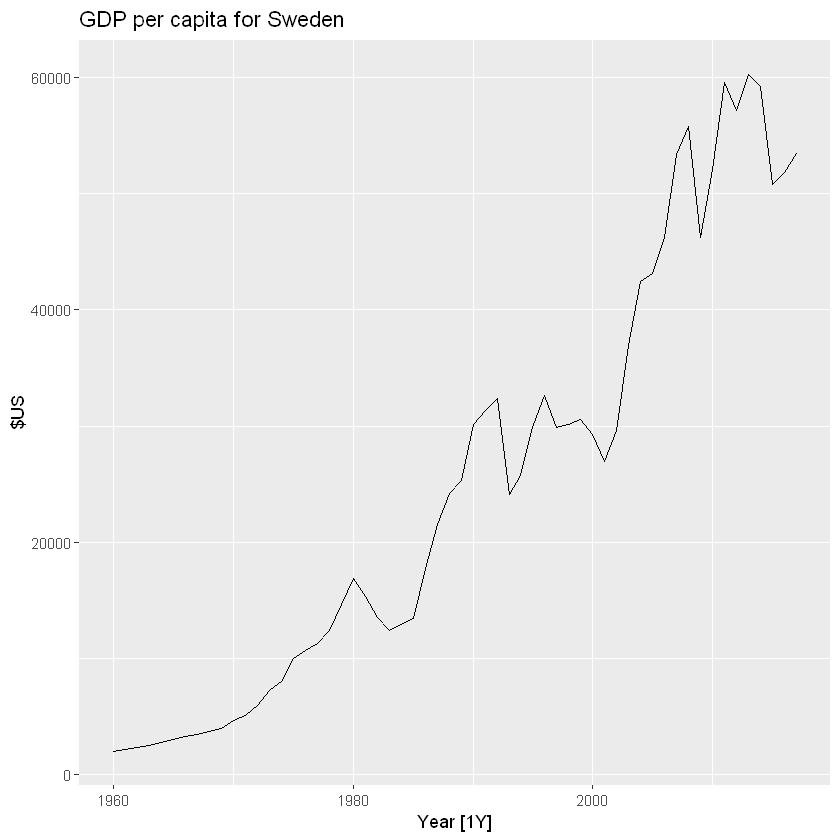

In [3]:
gdppc <- global_economy %>%
    mutate(GDP_per_capita = GDP / Population) %>%
    filter(Country == "Sweden")

gdppc %>% autoplot(GDP_per_capita) +
 labs(y='$US', title='GDP per capita for Sweden')

ggsave(paste(plot_prefix, 'sweden_gdp.png', sep='_'), height = 4, width =5)

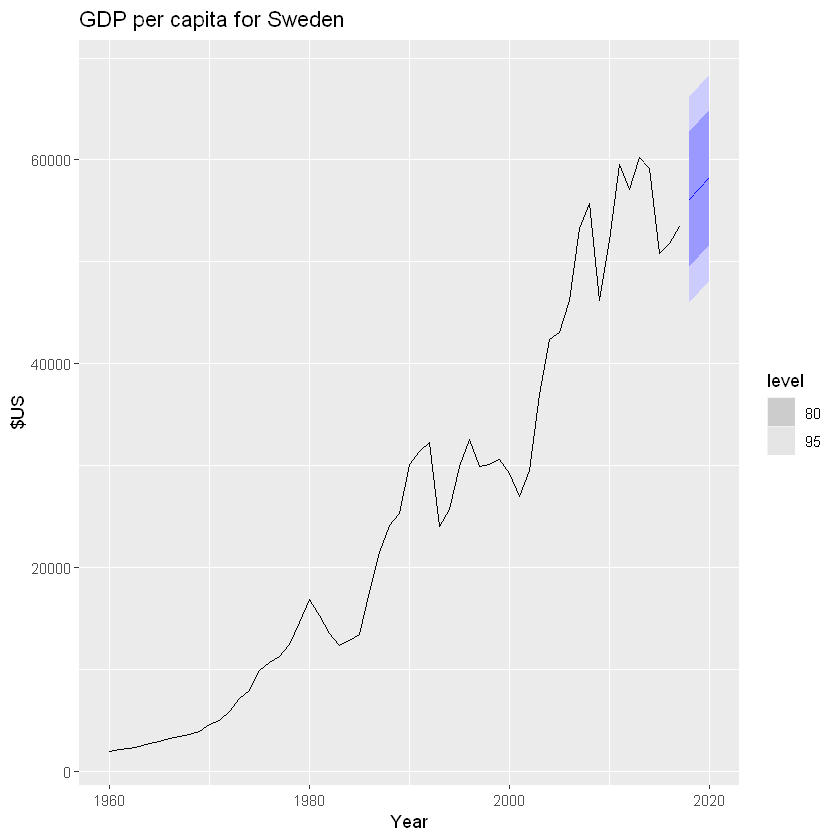

In [4]:
fit <- gdppc |>
  model(trend_model = TSLM(GDP_per_capita ~ trend()))

fit |>
  forecast(h = "3 years") |>
  filter(Country == "Sweden") |>
  autoplot(gdppc) +
  labs(y = "$US", title = "GDP per capita for Sweden")

  ggsave(paste(plot_prefix, 'sweden_gdp_forecast.png', sep='_'), height = 4, width =5)

## Air Passengers
### Split into training and test data

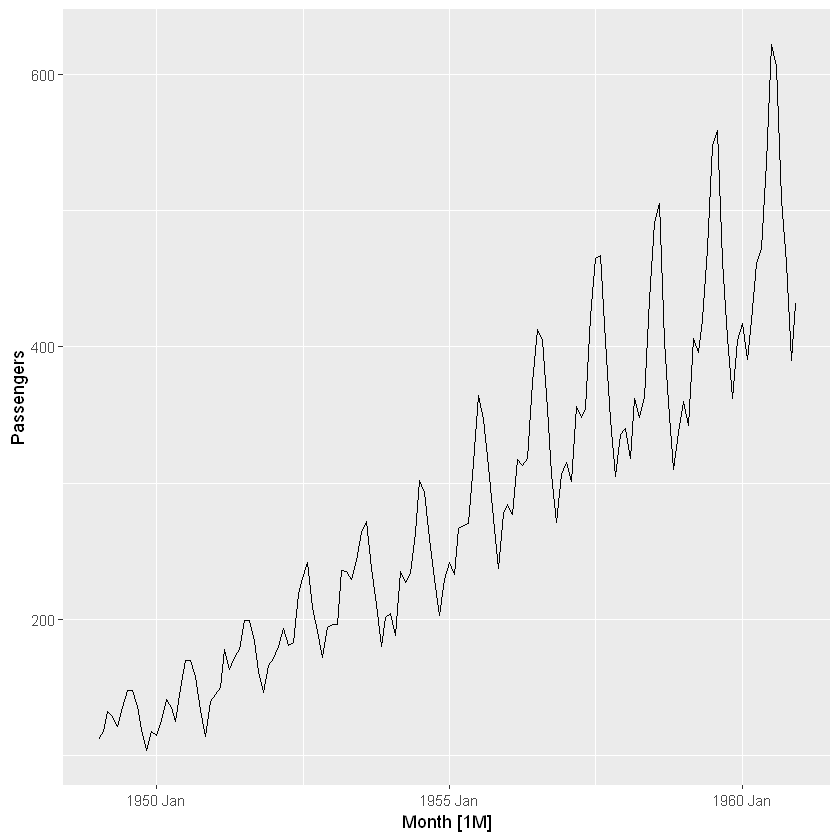

In [3]:
# Load AirPassengers, convert to tsibble and rename
data("AirPassengers")
ap <- AirPassengers %>% as_tsibble()
names(ap) <- c('Month', 'Passengers')
ap <- ap %>%
    mutate(LogPassengers = log(Passengers)) %>%
    mutate(dLogPassengers = difference(LogPassengers))

ap %>% autoplot(Passengers)
ggsave(paste(plot_prefix, 'ap_full series.png', sep='_'), height = 4, width =5)

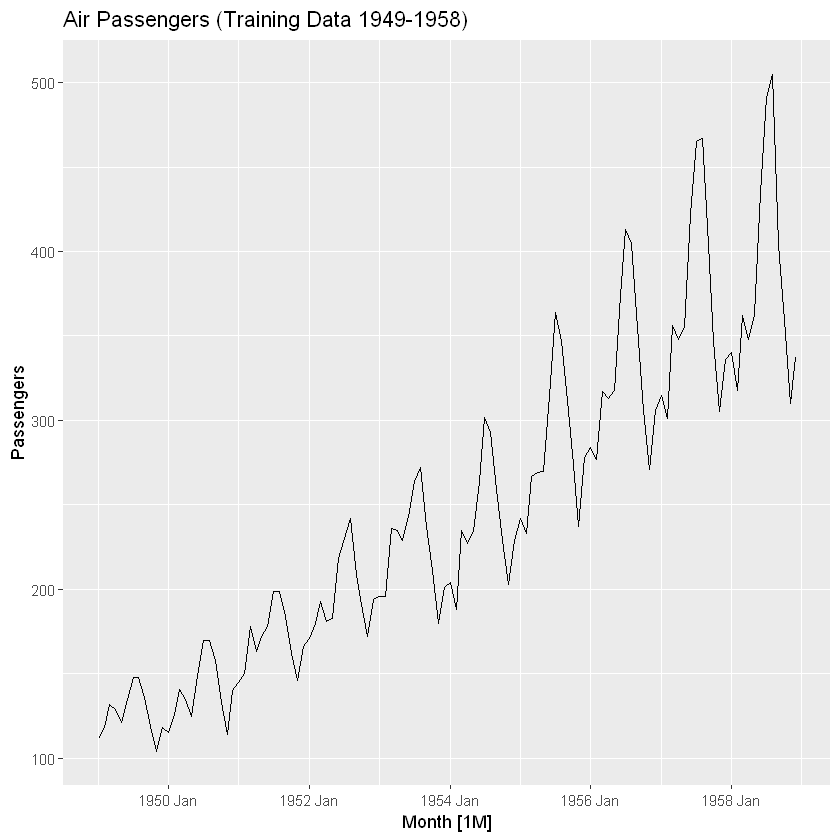

In [6]:
# Create training, test splits
ap_training <- ap %>% filter_index(. ~ "1958 Dec")
ap_test <- ap %>% filter_index("1959 Jan" ~ .)

# Plot the training data
ap_training %>% autoplot(Passengers) + ggtitle('Air Passengers (Training Data 1949-1958)')

ggsave(paste(plot_prefix, 'ap_training.png', sep='_'), height = 4, width =5)

In [7]:
mean(ap_training$Passengers)

[1] 245.9083

### Forecasts Using the Mean Method

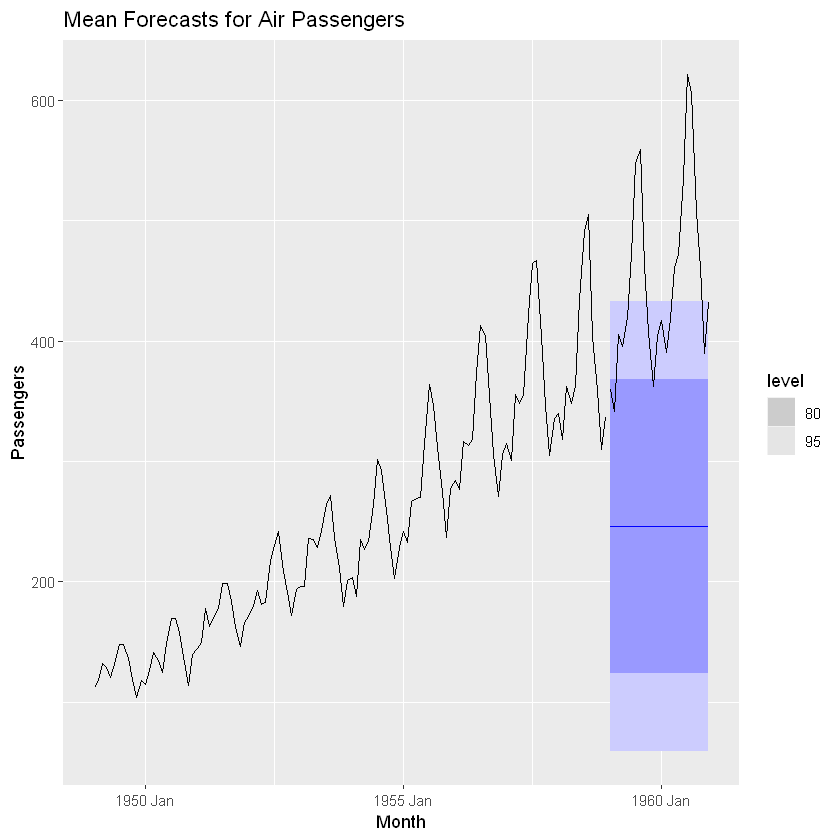

In [8]:
mean_model <- ap_training %>% model(MEAN(Passengers))
mean_forecasts <- mean_model %>% forecast(ap_test)

mean_forecasts %>% autoplot(ap_training) + ggtitle('Mean Forecasts for Air Passengers') +
  autolayer(ap_test, Passengers)

ggsave(paste(plot_prefix, 'ap_mean.png', sep='_'), height = 4, width =5)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


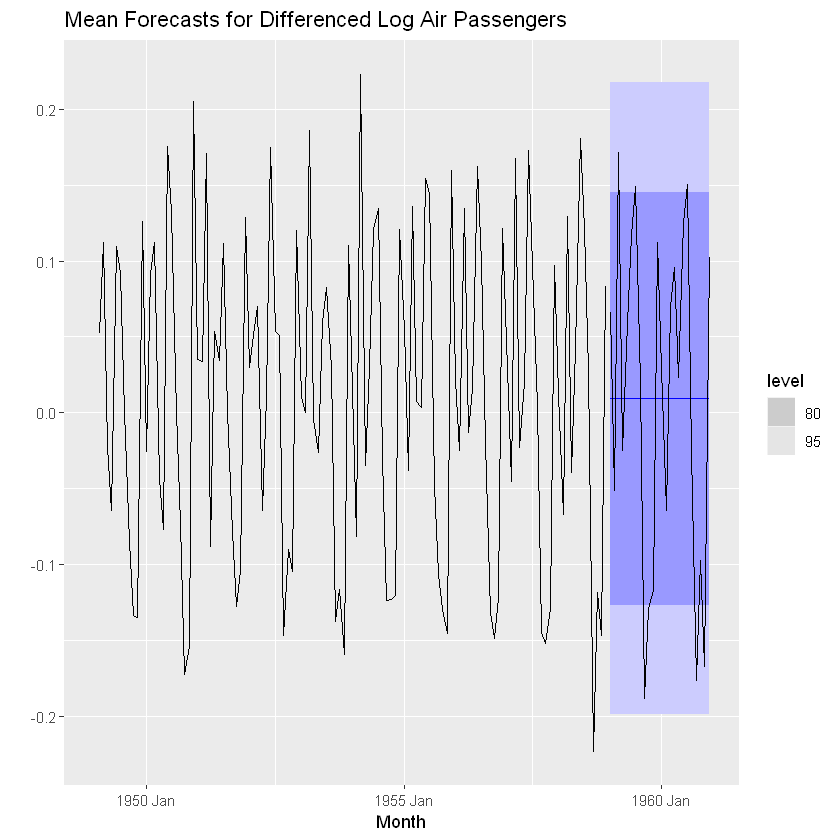

In [9]:
mean_model <- ap_training %>% model(MEAN(dLogPassengers))
mean_forecasts <- mean_model %>% forecast(ap_test)

mean_forecasts %>% autoplot(ap_training) + labs(y='') +
ggtitle('Mean Forecasts for Differenced Log Air Passengers') +
autolayer(ap_test, dLogPassengers)

ggsave(paste(plot_prefix, 'dlog_ap_mean.png', sep='_'), height = 4, width =5)


In [10]:
mean(ap_training$dLogPassengers, na.rm=TRUE)

[1] 0.009257009

In [11]:
tseries::adf.test(ap_training$dLogPassengers[!is.na(ap_training$dLogPassengers)])

Warning message in tseries::adf.test(ap_training$dLogPassengers[!is.na(ap_training$dLogPassengers)]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  ap_training$dLogPassengers[!is.na(ap_training$dLogPassengers)]
Dickey-Fuller = -6.3698, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [12]:
ap_training|>
  features(Passengers, unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
2.276234,0.01


In [13]:
ap_training|>
  features(dLogPassengers, unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.03938456,0.1


Warning message:
"The output of `fortify(<fable>)` has changed to better suit usage with the ggdist package.
If you're using it to extract intervals, consider using `hilo()` to compute intervals, and `unpack_hilo()` to obtain values."
Warning message:
"The output of `fortify(<fable>)` has changed to better suit usage with the ggdist package.
If you're using it to extract intervals, consider using `hilo()` to compute intervals, and `unpack_hilo()` to obtain values."
Warning message:
"The output of `fortify(<fable>)` has changed to better suit usage with the ggdist package.
If you're using it to extract intervals, consider using `hilo()` to compute intervals, and `unpack_hilo()` to obtain values."
Warning message:
"The output of `fortify(<fable>)` has changed to better suit usage with the ggdist package.
If you're using it to extract intervals, consider using `hilo()` to compute intervals, and `unpack_hilo()` to obtain values."


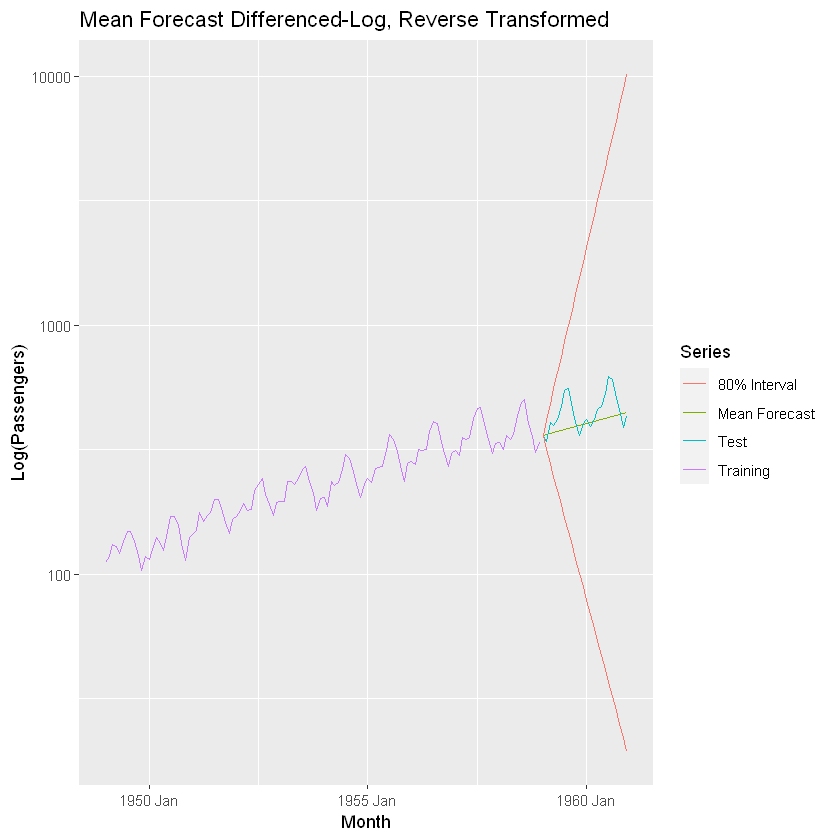

In [14]:
# Reverse the differenced log transformation
reversed_mean_forecasts <- mean_forecasts %>%
mutate(reversedForecast = exp(first(LogPassengers) + cumsum(.mean)-first(.mean))) %>%
mutate(reversed_lower80 = hilo(dLogPassengers, 80)$lower) %>%
mutate(reversed_lower80 = exp(first(LogPassengers) + cumsum(reversed_lower80)-first(reversed_lower80))) %>%
mutate(reversed_upper80 = hilo(dLogPassengers, 80)$upper) %>%
mutate(reversed_upper80 = exp(first(LogPassengers) + cumsum(reversed_upper80)-first(reversed_upper80))) 

ggplot() +
geom_line(data=ap_training, aes(x=Month, y=Passengers, colour='Training')) +
geom_line(data=reversed_mean_forecasts, aes(x=Month, y=reversedForecast, colour='Mean Forecast')) +
geom_line(data=reversed_mean_forecasts, aes(x=Month, y=Passengers, colour='Test')) +
geom_line(data=reversed_mean_forecasts, aes(x=Month, y=reversed_lower80, colour='80% Interval')) +
geom_line(data=reversed_mean_forecasts, aes(x=Month, y=reversed_upper80, colour='80% Interval')) +
guides(colour = guide_legend(title='Series')) +
scale_y_log10() +
labs(y='Log(Passengers)', title='Mean Forecast Differenced-Log, Reverse Transformed')

ggsave(paste(plot_prefix, 'dlog_ap_mean_reverse.png', sep='_'), height = 4, width =6)



Do again using the seasonally adjusted data, the interval will behave better.

### Produce an Initial Forecast Using the Naive Method

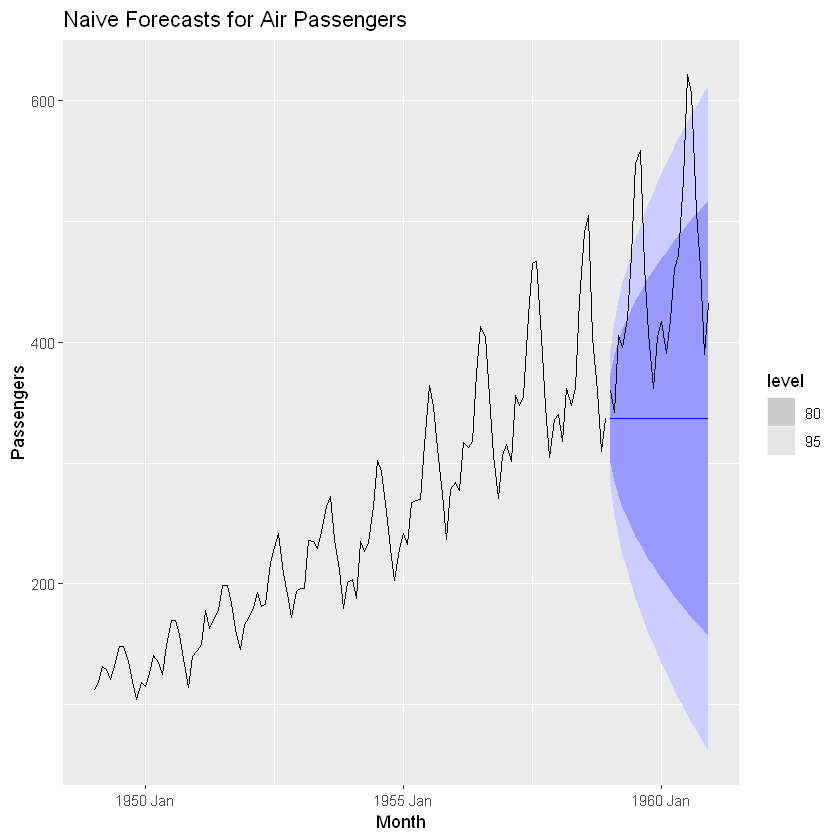

In [15]:
# Naive Forecast - Baseline
naive_model <- ap_training %>% model(NAIVE(Passengers))
naive_forecasts <- naive_model %>% forecast(ap_test)

naive_forecasts %>% autoplot(ap_training) + ggtitle('Naive Forecasts for Air Passengers') +
  autolayer(ap_test, Passengers)

ggsave(paste(plot_prefix, 'ap_naive.png', sep='_'), height = 4, width =6)

In [16]:
naive_acc <- fabletools::accuracy(naive_forecasts, ap_test)
naive_acc

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NAIVE(Passengers),Test,115.25,137.329,115.25,23.57747,23.57747,NaN,NaN,0.7282432


## Forecast Distribution - Summary of Potential Futures

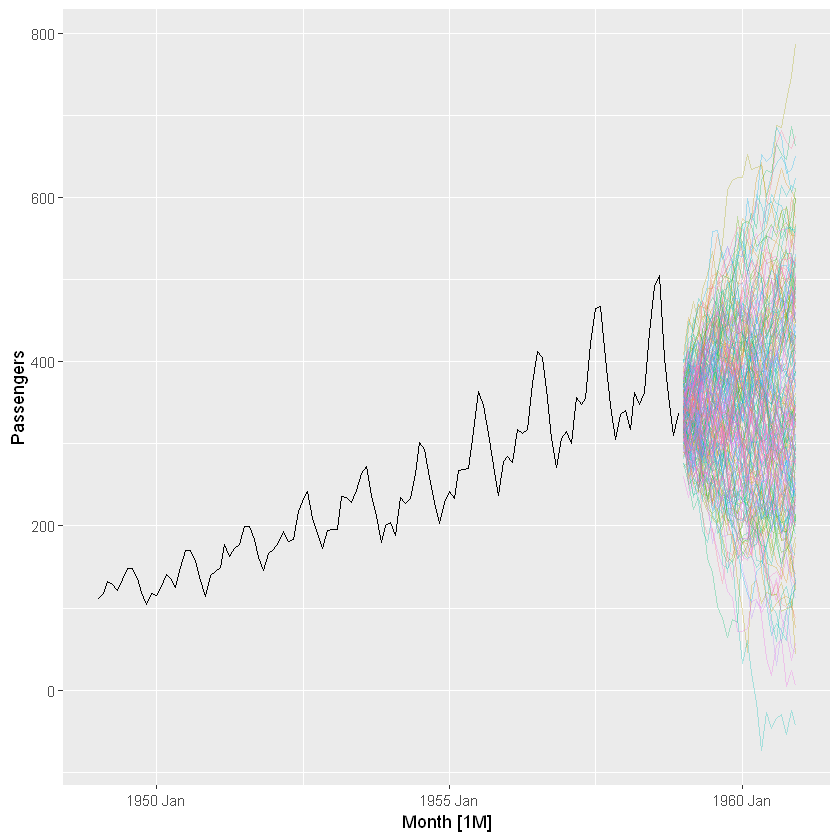

In [17]:
# Generate Forecasts - Futures of Naive with historical random errors
naive_gens <- naive_model %>% generate(h=24, times=200)

autoplot(ap_training, Passengers) +
  geom_line(aes(y=.sim, colour = as.factor(.rep)), data=naive_gens, alpha=.3) +
  guides(colour='none')

ggsave(paste(plot_prefix, 'ap_naive_dist.png', sep='_'), height = 4, width =6)

## Seasonal Naive Forecasts

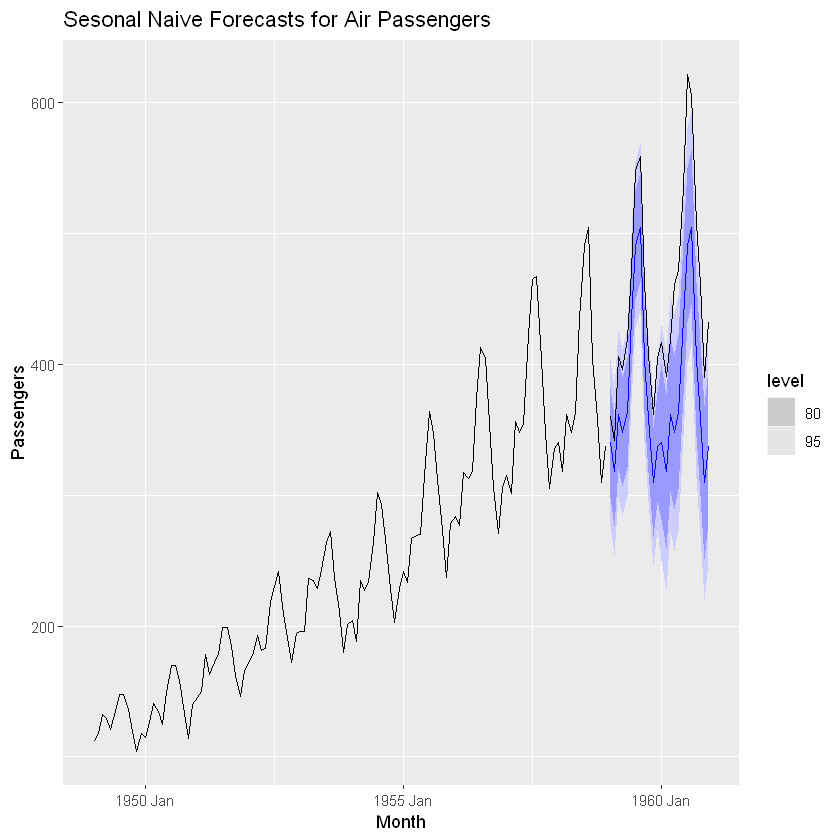

In [18]:
# Seasonal Naive Forecast - Baseline
snaive_model <- ap_training %>% model(SNAIVE(Passengers ~ lag("year")))
snaive_forecasts <- snaive_model %>% forecast(ap_test)

snaive_forecasts %>% autoplot(ap_training) + ggtitle('Sesonal Naive Forecasts for Air Passengers') +
  autolayer(ap_test, Passengers)

ggsave(paste(plot_prefix, 'ap_snaive.png', sep='_'), height = 4, width =6)

## Drift Forecasts

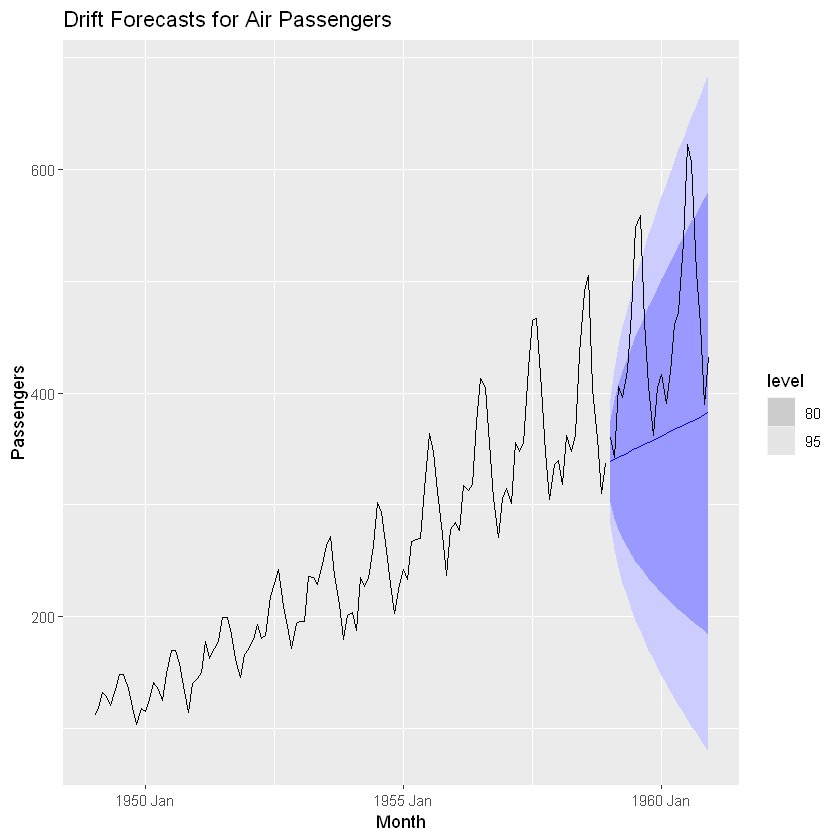

In [19]:
# Drift Forecast - Baseline
drift_model <- ap_training %>% model(RW(Passengers ~ drift()))
drift_forecasts <- drift_model %>% forecast(ap_test)

drift_forecasts %>% autoplot(ap_training) + ggtitle('Drift Forecasts for Air Passengers') +
  autolayer(ap_test, Passengers)

ggsave(paste(plot_prefix, 'ap_drift.png', sep='_'), height = 4, width =6)

## Comparing all the Forecasts (Naive, Mean, Seasonal Naive, Drift)

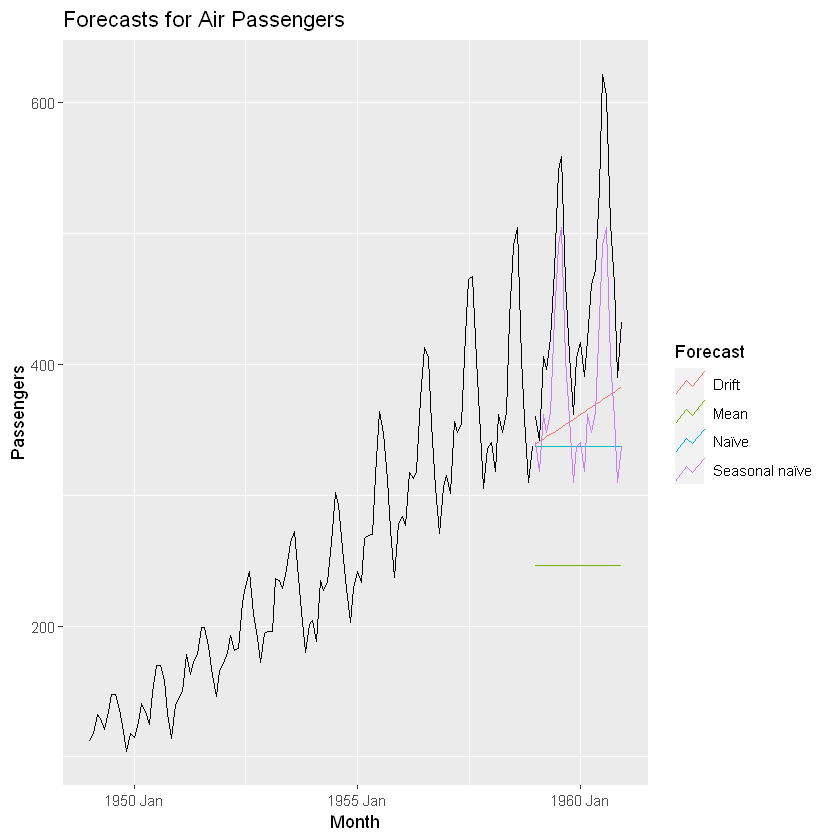

In [20]:
ap_fit <- ap_training |>
  model(
    Mean = MEAN(Passengers),
    `Naïve` = NAIVE(Passengers),
    `Seasonal naïve` = SNAIVE(Passengers ~ lag('year')),
    Drift = RW(Passengers ~ drift())
  )

# Generate forecasts for 14 quarters
ap_fc <- ap_fit |> forecast(h = 24)

# Plot forecasts against actual values
ap_fc |>
  autoplot(ap_training, level = NULL) +
  autolayer(ap_test, Passengers,
    colour = "black"
  ) +
  labs(
    y = "Passengers",
    title = "Forecasts for Air Passengers"
  ) +
  guides(colour = guide_legend(title = "Forecast"))

  ggsave(paste(plot_prefix, 'ap_basic_forecast_comp.png', sep='_'), height = 4, width =6)

In [21]:
fabletools::accuracy(ap_fc, ap)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Drift,Test,91.61555,115.70350,91.61555,18.40836,18.40836,3.206247,3.559437,0.7064390
Mean,Test,206.34167,219.43922,206.34167,44.23461,44.23461,7.221290,6.750704,0.7282432
Naïve,Test,115.25000,137.32898,115.25000,23.57747,23.57747,4.033377,4.224711,0.7282432
Seasonal naïve,Test,71.25000,76.99459,71.25000,15.52336,15.52336,2.493519,2.368618,0.7284628


## Comparing Random Walk with Drift Forecast Residuals for Passengers and Differenced-Log Passengers

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."


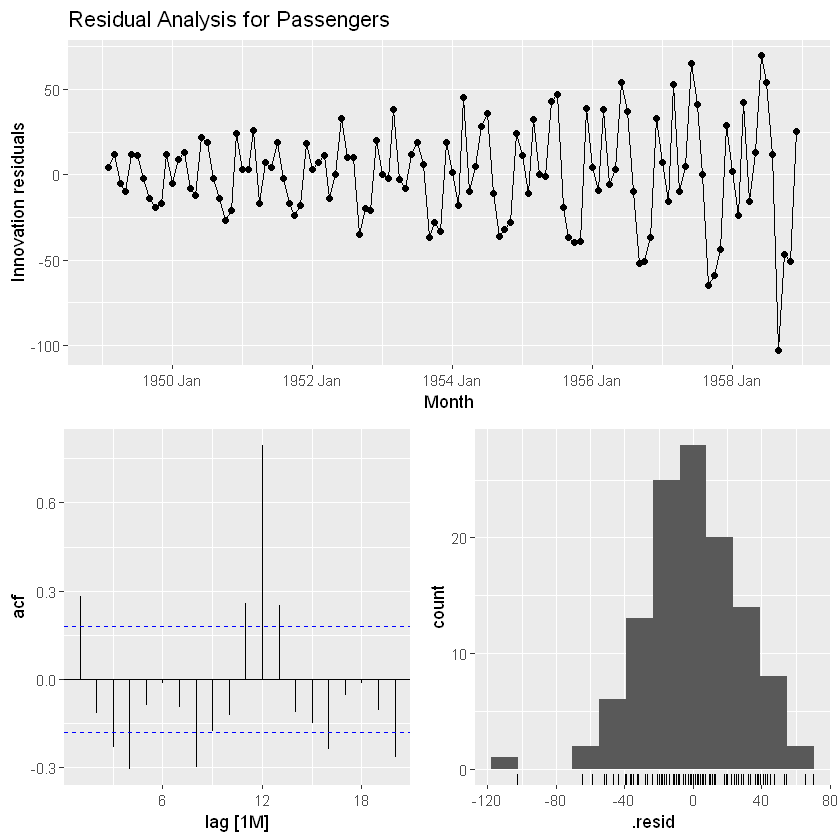

In [22]:
# Drift - Passengers
temp <- ap_training %>% 
    model(RW(Passengers ~ drift())) %>%
    gg_tsresiduals() +
    labs(title='Residual Analysis for Passengers')

temp

ggsave(paste(plot_prefix, 'ap_drift_level_residuals.png', sep='_'), plot=temp, height = 4, width =6)

Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite values (`stat_bin()`)."


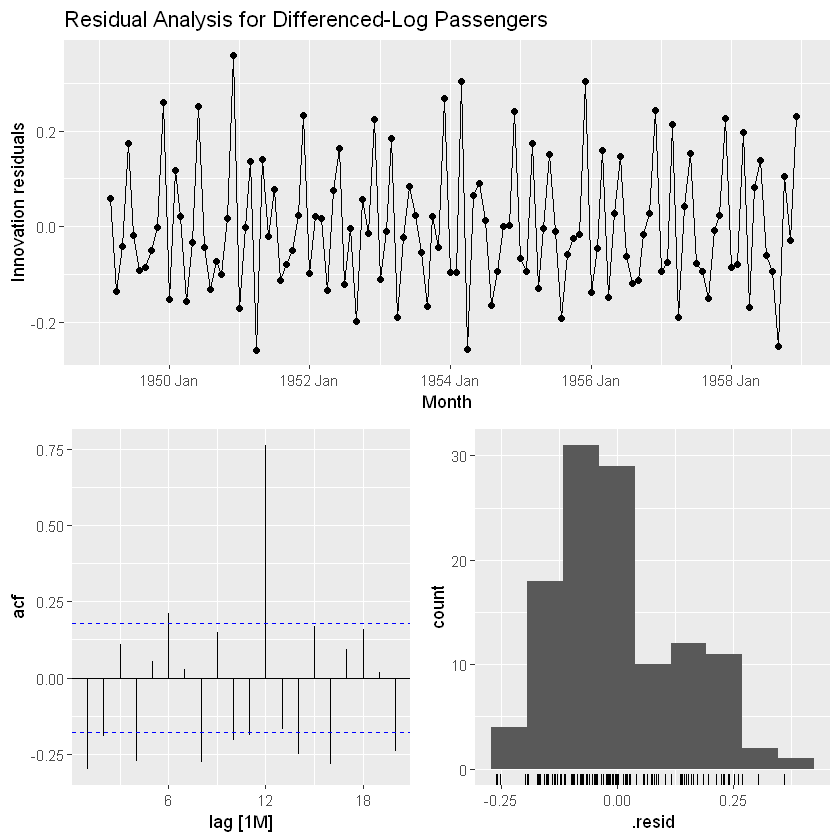

In [23]:
# Drift - Differenced Log
temp <- ap_training %>% 
    model(RW(dLogPassengers ~ drift())) %>%
    gg_tsresiduals() +
    labs(title='Residual Analysis for Differenced-Log Passengers')

temp
ggsave(paste(plot_prefix, 'ap_drift_differenced_residuals.png', sep='_'), plot=temp, height = 4, width =6)

In [24]:
ap_training %>% 
    model(RW(Passengers ~ drift())) %>%
    augment() %>%
    features(.innov, ljung_box, lag=12)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
RW(Passengers ~ drift()),143.4104,0


In [25]:
ap_training %>% 
    model(RW(dLogPassengers ~ drift())) %>%
    augment() %>%
    features(.innov, ljung_box, lag=12)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
RW(dLogPassengers ~ drift()),132.6381,0


## Example of Better Looking Residuals

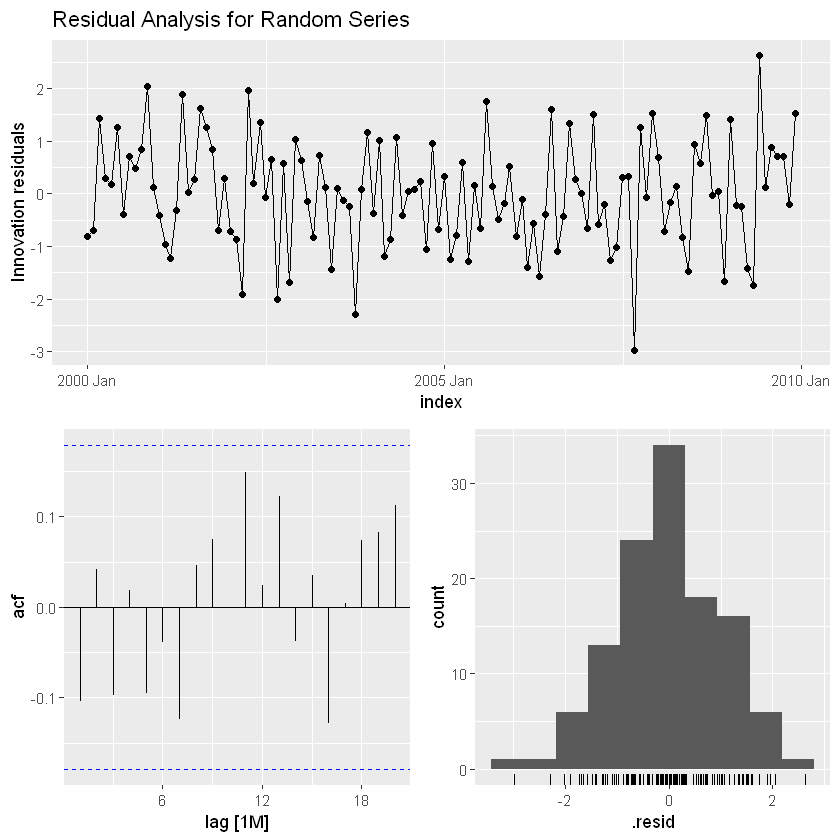

In [26]:
set.seed(10101)
random <- ts(rnorm(120), start=c(2000,1), freq=12) %>% as_tsibble()

random_mean <- random %>%
    model(MEAN(value)) %>%
    gg_tsresiduals() +
    labs(title='Residual Analysis for Random Series')

random_mean
ggsave(paste(plot_prefix, 'random_mean_residuals.png', sep='_'), plot=random_mean, height = 4, width =6)

In [27]:
random %>% 
    model(MEAN(value)) %>%
    augment() %>%
    features(.innov, ljung_box, lag=12)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
MEAN(value),10.18427,0.5997982


## Prediction Intervals and Bootstrapping

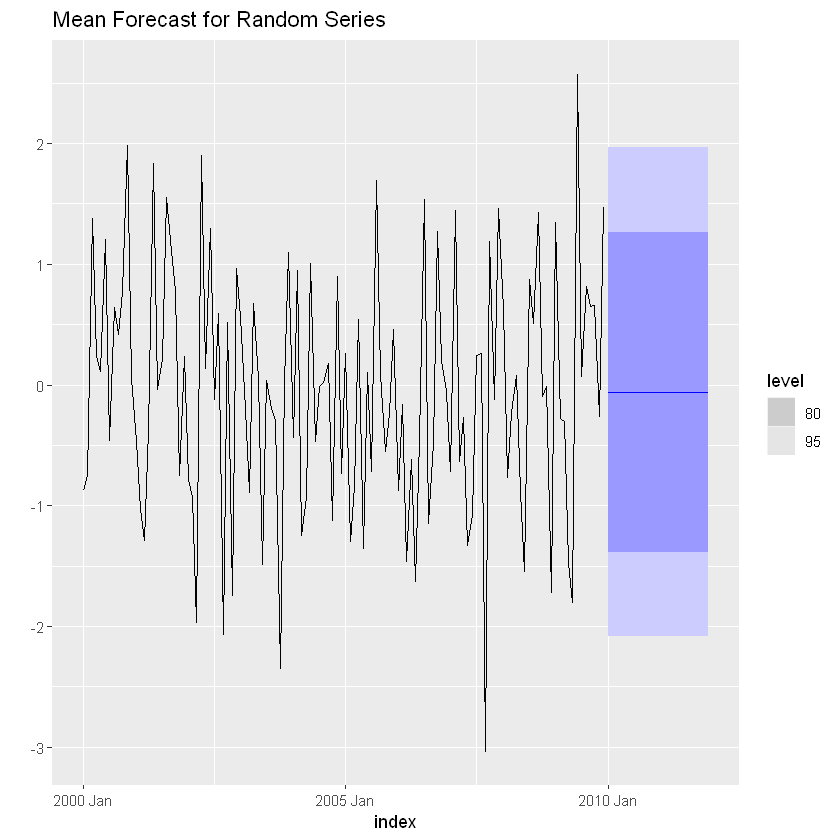

In [28]:
random %>% 
    model(MEAN(value))  %>%
    forecast(h=24) %>%
    autoplot(random) +
    labs(title='Mean Forecast for Random Series', y='')

ggsave(paste(plot_prefix, 'random_mean_prediction_interval.png', sep='_'), height = 4, width =6)

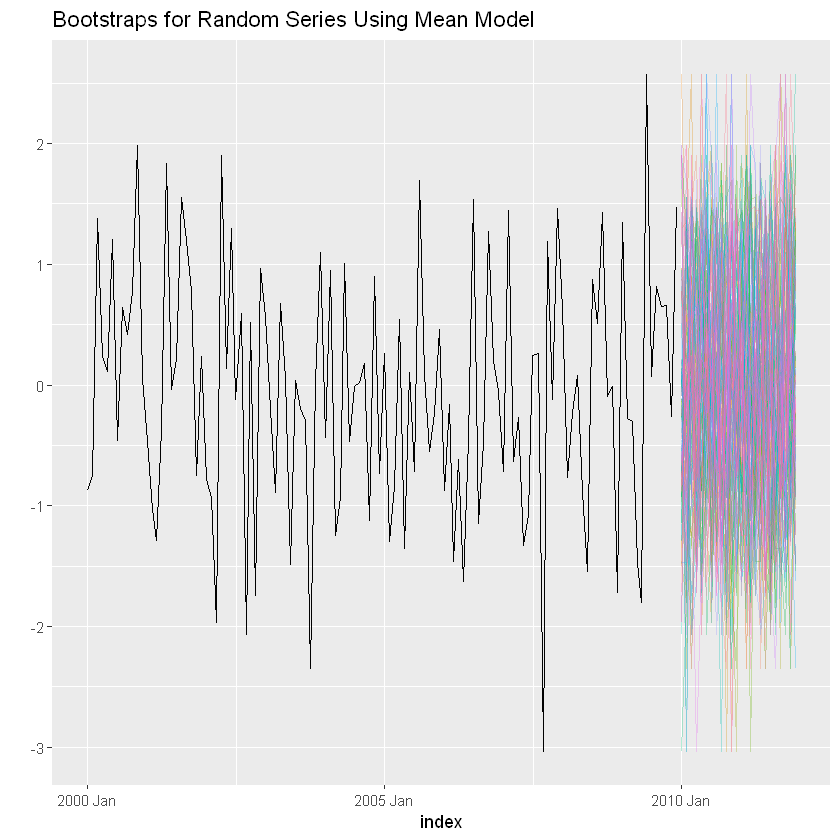

In [29]:
random_sim <- random %>% 
    model(MEAN(value))  %>%
    generate(h=24, times=100, bootstrap=TRUE)

random %>%
    ggplot(aes(x=index)) +
    geom_line(aes(y=value)) +
    geom_line(data=random_sim, aes(y = .sim, colour = as.factor(.rep)), alpha=0.3) +
    labs(title = 'Bootstraps for Random Series Using Mean Model', y='') +
    guides(colour='none')

ggsave(paste(plot_prefix, 'random_mean_bootstrap.png', sep='_'), height = 4, width =6)

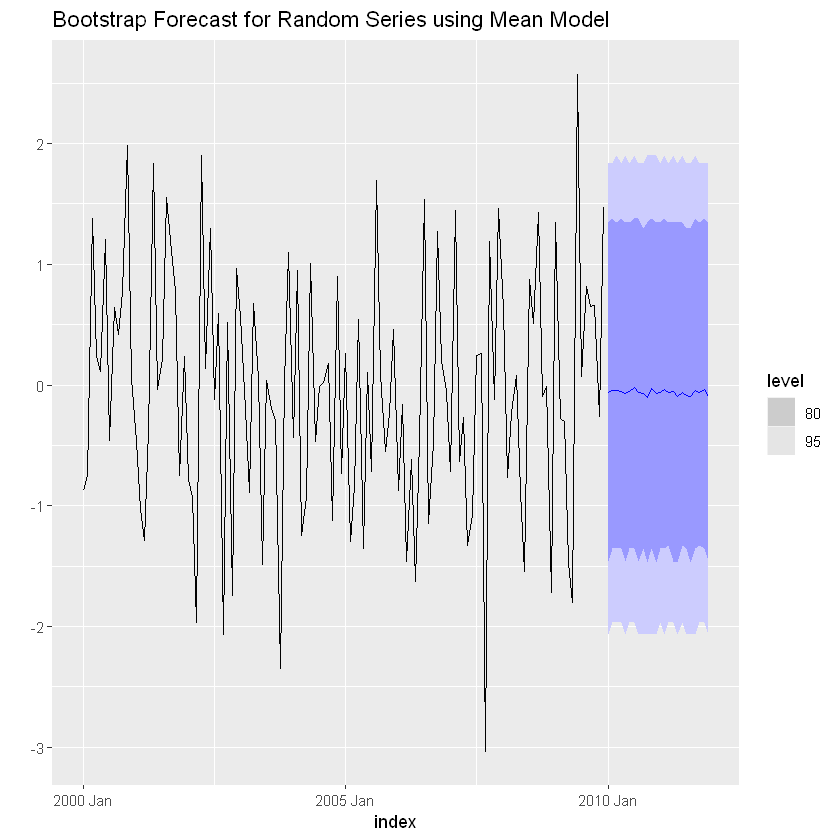

In [30]:
random_sim <- random %>% 
    model(MEAN(value))  %>%
    forecast(h=24, bootstrap=TRUE)

random_sim %>% autoplot(random) +
    labs(title='Bootstrap Forecast for Random Series using Mean Model', y='')

ggsave(paste(plot_prefix, 'random_mean_bootstrap_interval.png', sep='_'), height = 4, width =6)

## Forecasting with Decomposition

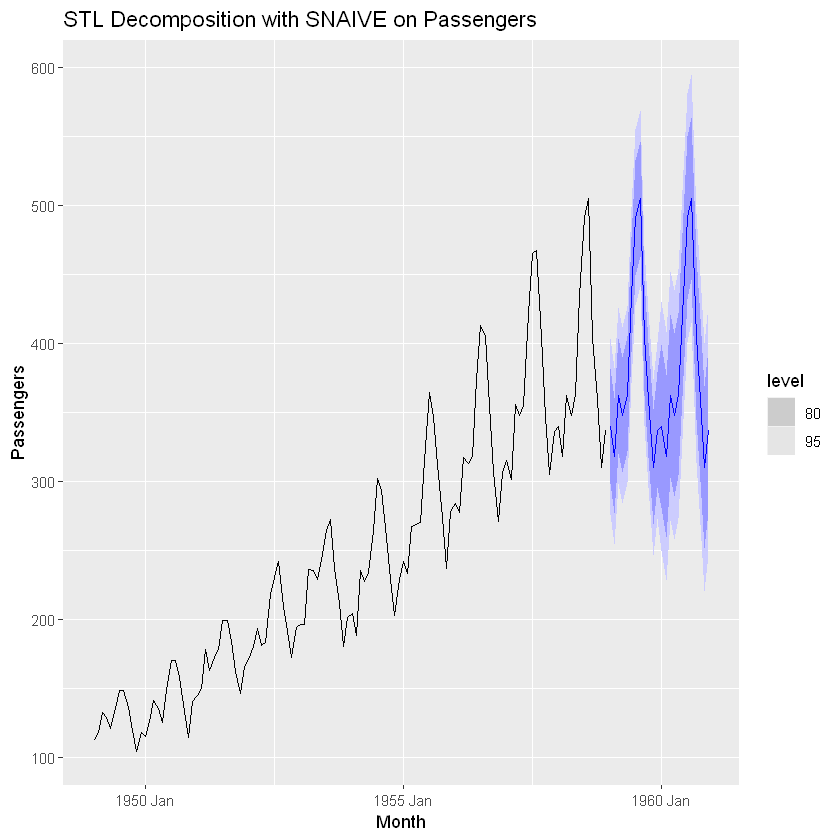

In [31]:
fcst <- ap_training %>%
    model(stlf = decomposition_model(STL(Passengers ~ trend(window=6), robust=TRUE), SNAIVE(season_adjust))) %>%
    forecast(ap_test)

fcst %>% autoplot(ap_training) +
    labs(title='STL Decomposition with SNAIVE on Passengers')

ggsave(paste(plot_prefix, 'ap_decomposition_forecast.png', sep='_'), height = 4, width =6)

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_bin()`)."


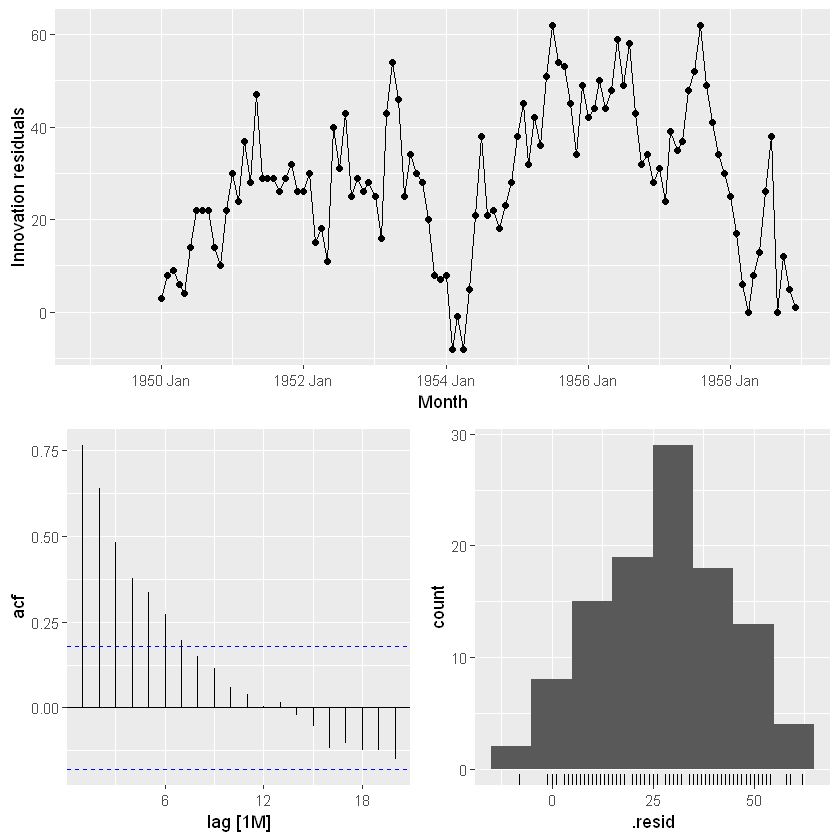

In [32]:
dcmp_resid <- ap_training %>%
    model(stlf = decomposition_model(STL(Passengers ~ trend(window=6), robust=TRUE), SNAIVE(season_adjust))) %>%
    gg_tsresiduals()

dcmp_resid
ggsave(paste(plot_prefix, 'ap_decomposition_residuals.png', sep='_'), plot=dcmp_resid, height = 4, width =6)

## Evaluating the Distribution

In [33]:
fabletools::accuracy(ap_fc, ap, list(qs=quantile_score), probs=c(0.1))

.model,.type,qs
<chr>,<chr>,<dbl>
Drift,Test,44.58697
Mean,Test,65.70415
Naïve,Test,47.78123
Seasonal naïve,Test,24.30720


In [34]:
fabletools::accuracy(ap_fc, ap, list(qs=quantile_score), probs=c(0.5))

.model,.type,qs
<chr>,<chr>,<dbl>
Drift,Test,91.61555
Mean,Test,206.34167
Naïve,Test,115.25000
Seasonal naïve,Test,71.25000


In [35]:
fabletools::accuracy(ap_fc, ap, list(winkler = winkler_score), level=80)

.model,.type,winkler
<chr>,<chr>,<dbl>
Drift,Test,411.1474
Mean,Test,1102.7598
Naïve,Test,485.2543
Seasonal naïve,Test,329.3323


In [36]:
fabletools::accuracy(ap_fc, ap, list(winkler = winkler_score), level=95)

.model,.type,winkler
<chr>,<chr>,<dbl>
Drift,Test,545.4552
Mean,Test,1951.3527
Naïve,Test,681.1928
Seasonal naïve,Test,384.6172


In [37]:
fabletools::accuracy(ap_fc, ap, list(crps = CRPS))

.model,.type,crps
<chr>,<chr>,<dbl>
Drift,Test,65.00825
Mean,Test,155.75103
Naïve,Test,79.52117
Seasonal naïve,Test,51.17886


In [38]:
fabletools::accuracy(ap_fc, ap, list(skill = skill_score(CRPS)))

.model,.type,skill
<chr>,<chr>,<dbl>
Drift,Test,-0.2702167
Mean,Test,-2.0432685
Naïve,Test,-0.5537892
Seasonal naïve,Test,0.0000000


## Rolling Evaluation

In [39]:
ap %>%
    model(RW(Passengers ~ drift())) %>%
    fabletools::accuracy()

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RW(Passengers ~ drift()),Training,-2.385087e-15,33.63605,25.68732,-0.5803771,9.000932,0.8019693,0.9262113,0.3028553


In [40]:
re <- ap %>% 
    stretch_tsibble(.init = 12, .step = 3) %>%
    relocate(Month, .id)

re %>%
    model(    Mean = MEAN(Passengers),
    `Naïve` = NAIVE(Passengers),
    `Seasonal naïve` = SNAIVE(Passengers ~ lag('year')),
    Drift = RW(Passengers ~ drift())) %>%
    forecast(h=1) %>%
    fabletools::accuracy(ap)

Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
1 observation is missing at 1961 Jan"


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Drift,Test,-0.1164901,32.30628,24.54655,-1.4768854,7.944754,0.7663540,0.8895943,-0.5008079
Mean,Test,102.4345021,129.78619,102.99944,29.5279467,30.015119,3.2156873,3.5738270,0.5449348
Naïve,Test,2.1590909,32.43770,24.61364,-0.6228673,7.876302,0.7684484,0.8932132,-0.4954393
Seasonal naïve,Test,33.0227273,37.60652,33.38636,11.3564702,11.516662,1.0423368,1.0355430,0.5860151
